# Etude du Covid-19 en France 
SIR Model sur les données du Covid-19

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
from scipy import optimize, integrate
import random 

In [98]:
data = pd.read_csv("donnees-hospitalieres-covid19-2020-05-05-19h00.csv",sep=';')

# Data Exploration

In [99]:
print(data.columns)
print(data.dtypes)
print("Dates entre", min(data['jour']) , "et",max(data['jour']), ", totale de", data['jour'].nunique(), "jours")

Index(['dep', 'sexe', 'jour', 'hosp', 'rea', 'rad', 'dc'], dtype='object')
dep     object
sexe     int64
jour    object
hosp     int64
rea      int64
rad      int64
dc       int64
dtype: object
Dates entre 2020-03-18 et 2020-05-05 , totale de 49 jours


In [100]:
data.describe()

,sexe,hosp,rea,rad,dc
count,14850.000000,14850.000000,14850.000000,14850.000000,14850.000000
mean,1.000000,157.342357,31.414074,167.986465,55.095825
std,0.816524,300.362171,64.017471,335.232762,120.594982
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,3.000000,15.000000,3.000000
50%,1.000000,52.000000,10.000000,50.000000,14.000000
75%,2.000000,142.000000,29.000000,161.000000,47.000000
max,2.000000,3281.000000,855.000000,4341.000000,1542.000000


In [101]:
data[(data.dep == "91") & (data.sexe == 0)]

,dep,sexe,jour,hosp,rea,rad,dc
273,91,0,2020-03-18,51,16,0,1
576,91,0,2020-03-19,82,22,4,1
879,91,0,2020-03-20,122,28,7,3
1182,91,0,2020-03-21,151,35,8,5
1485,91,0,2020-03-22,196,47,12,4
1788,91,0,2020-03-23,253,66,18,4
2091,91,0,2020-03-24,294,70,37,8
2397,91,0,2020-03-25,360,79,58,12
2700,91,0,2020-03-26,416,93,68,15
3003,91,0,2020-03-27,453,100,80,18


Text(0.5, 0, 'Date')

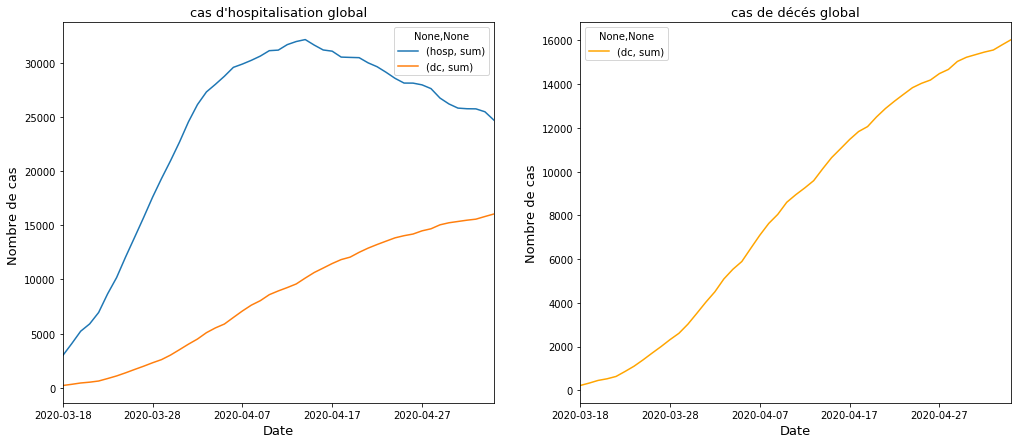

In [102]:
totalConfirme = data[data.sexe==0].groupby(['jour']).agg({'hosp':['sum']})
totalDC = data[data.sexe==0].groupby(['jour']).agg({'dc':['sum']})
totale = totalConfirme.join(totalDC)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
totale.plot(ax=ax1)
ax1.set_title("cas d'hospitalisation global", size=13)
ax1.set_ylabel("Nombre de cas ", size=13)
ax1.set_xlabel("Date", size=13)
totalDC.plot(ax=ax2, color='orange')
ax2.set_title("cas de décés global", size=13)
ax2.set_ylabel("Nombre de cas", size=13)
ax2.set_xlabel("Date", size=13)

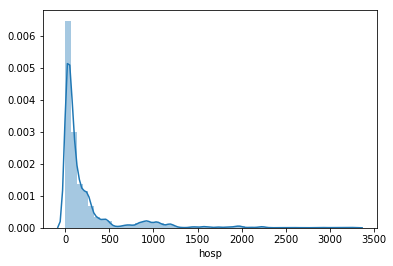

In [103]:
sns.distplot(data[data.sexe ==0].hosp)

In [104]:
dcTotal = data[(data.jour=='2020-05-05') & (data.sexe==0)].dc.sum()
dcHomme = data[(data.jour=='2020-05-05') & (data.sexe==1)].dc.sum()
dcFemme = data[(data.jour=='2020-05-05') & (data.sexe==2)].dc.sum()

In [105]:
f"décès total: {dcTotal}, Décès hommes:  {dcHomme}, Décès femmes:  {dcFemme},Décès non identifiés : {dcTotal-dcHomme-dcFemme} "


'décès total: 16041, Décès hommes:  9471, Décès femmes:  6522,Décès non identifiés : 48 '

In [106]:
values = [dcHomme,dcFemme,dcTotal-dcHomme-dcFemme]
labels = ["hommes","femmes","nonIdentifié"]

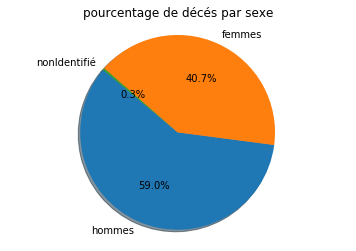

In [107]:
# Plot
plt.pie(values, labels=labels,autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('pourcentage de décés par sexe')
plt.show()

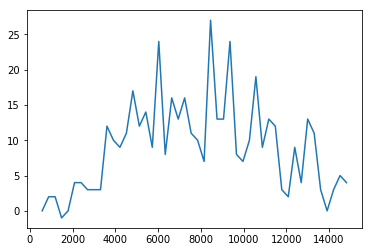

In [108]:
p = data[(data.dep == '91') & (data.sexe ==0) ].dc.diff()
plt.plot(p)

# Exemple du modéle SIR

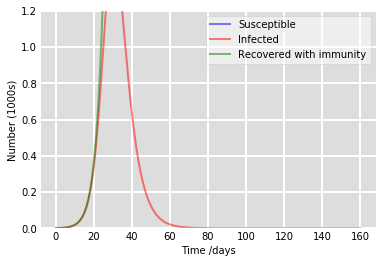

In [109]:
# Total population, N.
N = 10000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.6, 3./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T


# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions

# fit sur données synthetiques sans bruit 


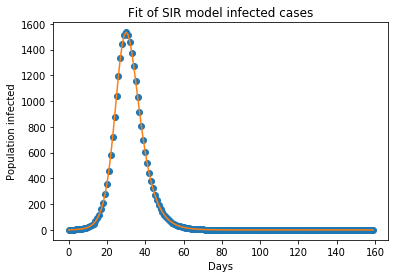

Optimal parameters: beta = 0.6037735849056587  and gamma =  0.30188679245282873


In [110]:

# fitg sur données synthetique sans bruit 
infected = I #géneré par le model SIR
newN = 10000 #comme celui d'avant 
expectedBeta = 0.6
expectedGama = 3./10

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = infected[0], 0
# Everyone else, S0, is susceptible to infection initially.
S0 = newN - I0 - R0

x = [i for i in range (0,160)]
y = infected


def sir_model(y, x, betas, gammas):
    sus = -betas * y[0] * y[1] / newN
    rec = gammas * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, betas, gammas):
    return integrate.odeint(sir_model, (S0, I0, R0), x, args=(betas, gammas))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, x, y)
fitted = fit_odeint(x, *popt)


plt.plot(x, y, 'o')
plt.plot(x, fitted)
plt.title("Fit of SIR model infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])


# fit sur données synthetiques avec bruit 


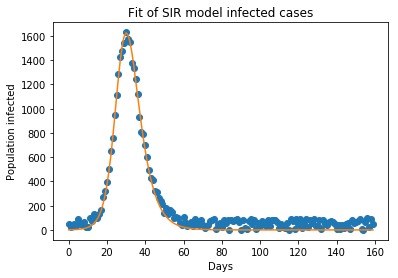

Optimal parameters: beta = 0.5920920551024336  and gamma =  0.2884061067317876


In [111]:

# fit sur données synthetique avec bruit 
infected = I #géneré par le model SIR
newN = 10000 #comme celui d'avant 
expectedBeta = 0.6
expectedGama = 3./10

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = infected[0], 0
# Everyone else, S0, is susceptible to infection initially.
S0 = newN - I0 - R0

x = [i for i in range (0,160)]
y = infected +np.random.randint(100, size=160)


def sir_model(y, x, betas, gammas):
    sus = -betas * y[0] * y[1] / newN
    rec = gammas * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, betas, gammas):
    return integrate.odeint(sir_model, (S0, I0, R0), x, args=(betas, gammas))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, x, y)
fitted = fit_odeint(x, *popt)


plt.plot(x, y, 'o')
plt.plot(x, fitted)
plt.title("Fit of SIR model infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])


# fit sur données réelles


<class 'list'>


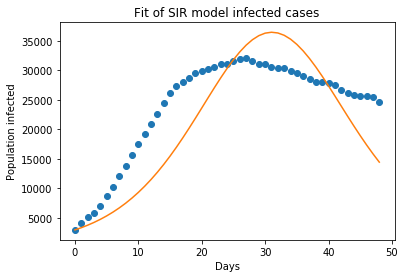

parameters: beta = 3.706337510159383  and gamma =  3.5868948193817904


In [112]:
infected = list((data[data.sexe==0]).groupby(['jour'])["hosp"].sum())

print(type(infected))

newN = 64000000

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = infected[0], 0
# Everyone else, S0, is susceptible to infection initially.
S0 = newN - I0 - R0

x = [i for i in range (0,len(infected))]
y = infected 


def sir_model(y, x, betas, gammas):
    sus = -betas * y[0] * y[1] / newN
    rec = gammas * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, betas, gammas):
    return integrate.odeint(sir_model, (S0, I0, R0), x, args=(betas, gammas))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, x, y)
fitted = fit_odeint(x, *popt)


plt.plot(x, y, 'o')
plt.plot(x, fitted)
plt.title("Fit of SIR model infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("parameters: beta =", popt[0], " and gamma = ", popt[1])
